## LightGBM Pediction Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100
sns.set_style("white")
%matplotlib inline

In [2]:
# read input 
full_concat_df = pd.read_csv("df_to_RF_model.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (130,131,132,135,136,137,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Encode loan_status as target

In [3]:
full_concat_df['target'] = full_concat_df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

In [4]:
encode_vars = ['tax_liens_le', 'home_ownership_le','verification_status_le','emp_length_impute_num', 
               'emp_title_truncated_impute_le','zip_code_truncated_le','term_encode', 'purpose_le']

num_vars = ['pub_rec_bankruptcies','dti','loan_amnt', 'annual_inc' ,'loan_income_ratio','fico_range_low','fico_range_high']





### Encode loan_status as target

In [5]:
predict_features = num_vars + encode_vars

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)

#split into train and test to avoid overfitting
train_df = full_concat_df
# train_df = full_concat_df

X_train, X_test, y_train, y_test = train_test_split(full_concat_df[predict_features], full_concat_df['target'], stratify=full_concat_df['target'], test_size=0.2, random_state=42)


In [7]:
X_train.shape, y_train.shape

((5268, 15), (5268,))

Grid search

In [8]:
import lightgbm as lgb
import copy
greater_is_better = False

lgb_metric = 'binary_logloss'
default_lgb_params = {}
default_lgb_params["objective"] = "binary"
default_lgb_params["learning_rate"] = 0.05
default_lgb_params["metric"] = lgb_metric
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234

params_lgb_space = {}
params_lgb_space['feature_fraction'] = [0.1, 0.3, 0.5, 0.7, 0.9]
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127]
params_lgb_space['max_depth'] = [3, 7, 10, 15, 31, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['bagging_fraction'] = [0.2, 0.4, 0.6, 0.8, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [0, 0.0001, 0.001, 0.1, 1, 3, 10]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10]


best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(X_train,
                            label=y_train
                            ),
                num_boost_round=100000,
                nfold=5,
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=False)
        if greater_is_better:
            best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
        else:
            best_lgb_score = min(lgb_cv['%s-mean' % (lgb_metric)])
        best_lgb_iteration = len(lgb_cv['%s-mean' % (lgb_metric)])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)    


 Tuning parameter feature_fraction in [0.1, 0.3, 0.5, 0.7, 0.9]

    feature_fraction: 0.1
, best_score: 0.434911, best_iteration: 88

    feature_fraction: 0.3
, best_score: 0.431121, best_iteration: 66

    feature_fraction: 0.5
, best_score: 0.427188, best_iteration: 48

    feature_fraction: 0.7
, best_score: 0.426883, best_iteration: 42

    feature_fraction: 0.9
, best_score: 0.427244, best_iteration: 35
Best feature_fraction is 0.7 with a score of 0.426883

 Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127]

    num_leaves: 3
, best_score: 0.423427, best_iteration: 127

    num_leaves: 7
, best_score: 0.424723, best_iteration: 85

    num_leaves: 15
, best_score: 0.425591, best_iteration: 60

    num_leaves: 31
, best_score: 0.426883, best_iteration: 42

    num_leaves: 63
, best_score: 0.430378, best_iteration: 28

    num_leaves: 127
, best_score: 0.431851, best_iteration: 29
Best num_leaves is 3 with a score of 0.423427

 Tuning parameter max_depth in [3, 7, 10, 15, 31,

In [9]:
print ('\n Best manually tuned parameters:', best_lgb_params)    


 Best manually tuned parameters: {'objective': 'binary', 'learning_rate': 0.05, 'metric': 'binary_logloss', 'bagging_freq': 1, 'seed': 1234, 'feature_fraction': 0.7, 'num_leaves': 3, 'max_depth': 3, 'min_gain_to_split': 1, 'bagging_fraction': 0.6, 'min_sum_hessian_in_leaf': 0, 'lambda_l2': 10, 'lambda_l1': 0}


In [10]:
model = lgb.train(best_lgb_params,
                  lgb.Dataset(X_train,
                              label=y_train
                              ),
                  num_boost_round=best_lgb_iteration)
y_pred_prob = model.predict(X_test)


### LightGBM Prediction and Performance Evaluation 

Confusion matrix

In [11]:
y_pred = []
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]>=0.2:      
       y_pred.append(1)
    else:  
       y_pred.append(0)

In [12]:
confusion_matrix(y_test, y_pred)
pd_confusion_matrix = pd.DataFrame(data = confusion_matrix(y_test, y_pred), columns=['Predicted Not charge-off', 'Predicted Charge-off'], index=['Not Chargeoff', 'Charge-off'])
pd_confusion_matrix

,Predicted Not charge-off,Predicted Charge-off
Not Chargeoff,799,300
Charge-off,105,114


Grid serach to find the optimal hyperparameters

roc_auc score 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.683


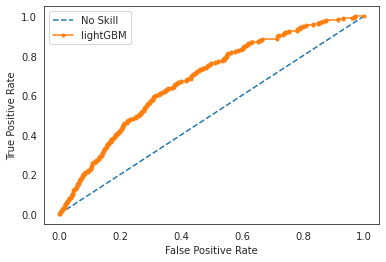

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pylab as plt

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
# keep probabilities for the positive outcome only
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
gbm_auc = roc_auc_score(y_test, y_pred_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (gbm_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
gbm_fpr, gbm_tpr, _ = roc_curve(y_test, y_pred_prob)
# plot the roc curve for the mode
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(gbm_fpr, gbm_tpr, marker='.', label='lightGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

gini coefficient and kolmogorov-smirnov are common used in credit-risk industry

In [14]:
y_hat_test_proba = model.predict(X_test)

In [15]:
y_hat_test_proba_char_off = y_hat_test_proba

In [16]:
df_test_y = pd.DataFrame(y_test)
df_test_y.reset_index(drop = True, inplace = True)

In [17]:
df_t_test_prob = pd.DataFrame(y_hat_test_proba_char_off)

In [18]:
df_actual_predicted_probs = pd.concat([df_test_y, df_t_test_prob], axis = 1,ignore_index=False)


In [19]:
df_actual_predicted_probs.index = X_test.index

In [20]:

df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [21]:
df_probs_threashold = df_actual_predicted_probs.sort_values('y_hat_test_proba',ascending=False)


In [22]:
df_probs_threashold = df_probs_threashold.reset_index(drop=True)

In [23]:
# check the prob_threashold of charge-off

df_probs_threashold['Cumulative N Population'] = df_probs_threashold.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_probs_threashold['Cumulative N Charge-off'] = df_probs_threashold['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_probs_threashold['Cumulative N Good'] = df_probs_threashold['Cumulative N Population'] - df_probs_threashold['loan_data_targets_test'].cumsum()



In [24]:
df_probs_threashold['Cumulative Perc Population'] = df_probs_threashold['Cumulative N Population'] / (df_probs_threashold.shape[0])
# We calculate the cumulative percentage of all observations.
df_probs_threashold['Cumulative Perc Charge-off'] = df_probs_threashold['Cumulative N Charge-off'] / df_probs_threashold['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_probs_threashold['Cumulative Perc Good'] = df_probs_threashold['Cumulative N Good'] / (df_probs_threashold.shape[0] - df_probs_threashold['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.

Text(0.5, 1.0, 'Gini')

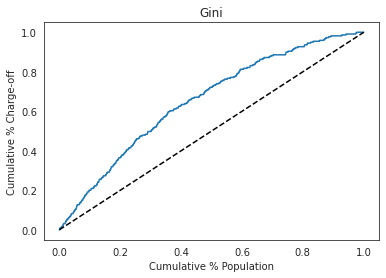

In [25]:
# Plot Gini
plt.plot(df_probs_threashold['Cumulative Perc Population'], df_probs_threashold['Cumulative Perc Charge-off'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_probs_threashold['Cumulative Perc Population'], df_probs_threashold['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Charge-off')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [26]:
gini_coef = 2*gbm_auc-1
gini_coef

0.36554194140792173

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

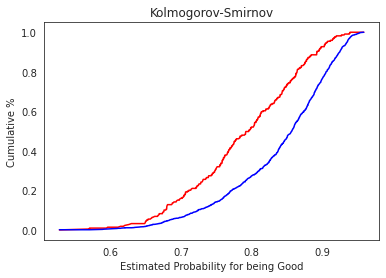

In [27]:
# Plot KS
plt.plot(1-df_probs_threashold['y_hat_test_proba'], df_probs_threashold['Cumulative Perc Charge-off'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'charge-off' along the y-axis,
# colored in red.
plt.plot(1-df_probs_threashold['y_hat_test_proba'], df_probs_threashold['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [28]:
KS = max(df_probs_threashold['Cumulative Perc Charge-off'] - df_probs_threashold['Cumulative Perc Good'])
KS

0.28789144136845035

### The lightGBM Classifie Performance Summeries
- Random forest model has roc_ruc 0.683
- The Gini coefficient is 0.365
- The max diff in Kolmogrov-Smirnov curve is 0.287

In [30]:
KS

0.28789144136845035

## False Positive Samples

In [31]:
X_test.head()

,pub_rec_bankruptcies,dti,loan_amnt,annual_inc,loan_income_ratio,fico_range_low,fico_range_high,tax_liens_le,home_ownership_le,verification_status_le,emp_length_impute_num,emp_title_truncated_impute_le,zip_code_truncated_le,term_encode,purpose_le
3509,0,28.57,10800,57000.0,0.189474,690,694,0,0,1,1,19,63,0,2
5714,0,19.61,11000,32500.0,0.338462,660,664,0,1,2,1,19,94,0,2
773,0,21.14,16000,50000.0,0.320000,685,689,0,0,2,1,19,69,1,2
3009,0,12.72,15000,85000.0,0.176471,765,769,0,2,2,10,19,45,0,2
6040,0,17.11,10000,92000.0,0.108696,730,734,0,0,0,5,19,94,0,10


In [32]:
y_test.head()

3509    0
5714    0
773     1
3009    0
6040    0
Name: target, dtype: int64

In [35]:
# y_pred

### Select the top 10% false positive 

In [56]:
test_predict_results_df = pd.DataFrame(y_test)

In [57]:
len(test_predict_results_df)

1318

In [58]:
test_predict_results_df = test_predict_results_df.reset_index()
len(test_predict_results_df)

1318

In [59]:
len(y_hat_test_proba)

1318

In [60]:
len(test_predict_results_df)

1318

In [61]:
test_predict_results_df = pd.concat([test_predict_results_df,pd.DataFrame(y_hat_test_proba)],axis=1,ignore_index=True)
test_predict_results_df.head()

,0,1,2
0,3509,0,0.168202
1,5714,0,0.257715
2,773,1,0.332991
3,3009,0,0.061937
4,6040,0,0.095382


In [62]:
test_predict_results_df.columns = ['id','is_default', 'default_prob']
test_predict_results_df.head()

,id,is_default,default_prob
0,3509,0,0.168202
1,5714,0,0.257715
2,773,1,0.332991
3,3009,0,0.061937
4,6040,0,0.095382


In [64]:
default_rate_sort_df = test_predict_results_df.sort_values('default_prob', ascending=False)

In [68]:
default_rate_sort_df['deault_prob_rank']  = default_rate_sort_df['default_prob'].rank(method='dense',ascending=False)

In [69]:
default_rate_sort_df.head()

,id,is_default,default_prob,deault_prob_rank
1299,249,0,0.472645,1.0
830,2499,1,0.430273,2.0
302,1525,1,0.429991,3.0
667,810,0,0.418277,4.0
895,6248,0,0.411712,5.0


In [89]:
default_rate_sort_df[default_rate_sort_df['is_default']==0][:50]

,id,is_default,default_prob,deault_prob_rank
1299,249,0,0.472645,1.0
667,810,0,0.418277,4.0
895,6248,0,0.411712,5.0
115,2093,0,0.409889,6.0
1271,3304,0,0.405994,7.0
1086,1190,0,0.400236,9.0
990,3299,0,0.396124,10.0
433,237,0,0.390919,11.0
6,2470,0,0.389587,12.0
738,2393,0,0.384972,14.0


In [90]:
most_50_false_pos_id = default_rate_sort_df[default_rate_sort_df['is_default']==0][:50].id

In [91]:
X_most_50_false_pos_df = X_test.loc[most_50_false_pos_id]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


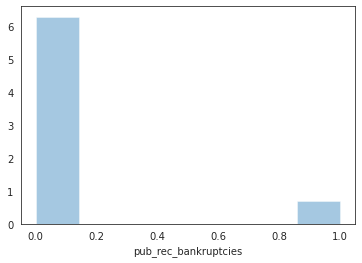

In [92]:
sns.distplot(X_most_50_false_pos_df['pub_rec_bankruptcies'])

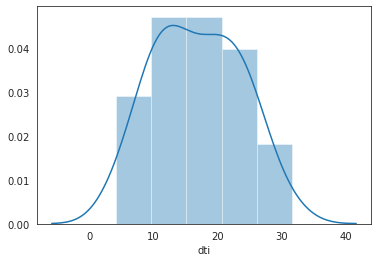

In [93]:
sns.distplot(X_most_50_false_pos_df['dti'])

In [ ]:
sns.distplot(X_most_50_false_pos_df['dti'])

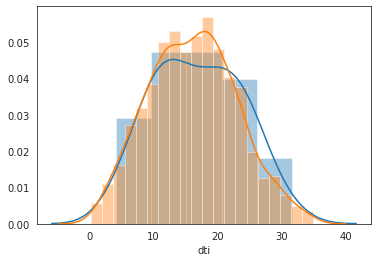

In [109]:
x = X_most_50_false_pos_df['dti']
y = X_test['dti']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

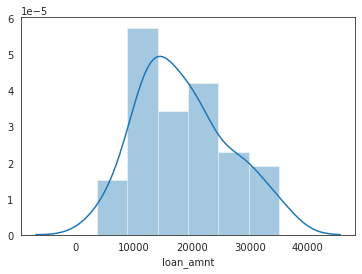

In [94]:
sns.distplot(X_most_50_false_pos_df['loan_amnt'])

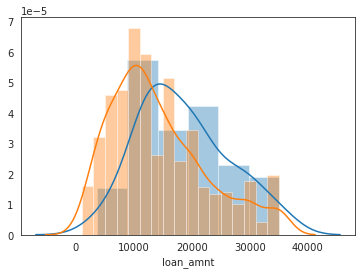

In [110]:
x = X_most_50_false_pos_df['loan_amnt']
y = X_test['loan_amnt']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

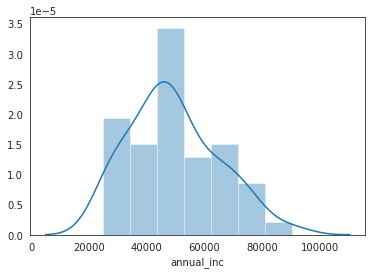

In [95]:

sns.distplot(X_most_50_false_pos_df['annual_inc'])

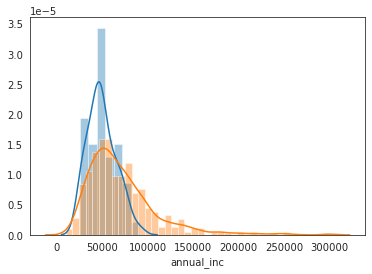

In [111]:
x = X_most_50_false_pos_df['annual_inc']
y = X_test['annual_inc']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

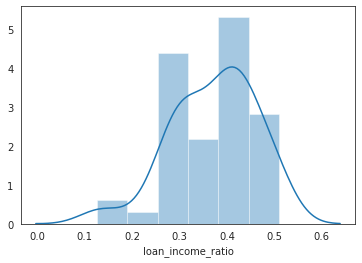

In [96]:
sns.distplot(X_most_50_false_pos_df['loan_income_ratio'])

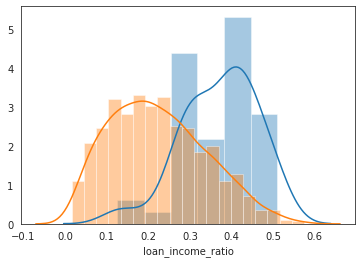

In [112]:
x = X_most_50_false_pos_df['loan_income_ratio']
y = X_test['loan_income_ratio']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

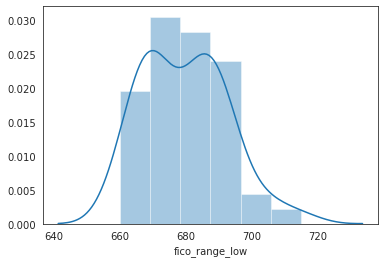

In [97]:

sns.distplot(X_most_50_false_pos_df['fico_range_low'])

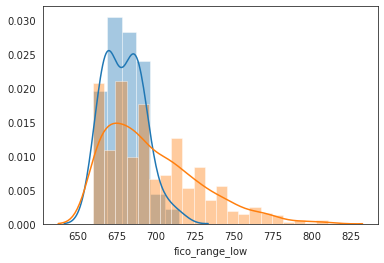

In [113]:
x = X_most_50_false_pos_df['fico_range_low']
y = X_test['fico_range_low']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

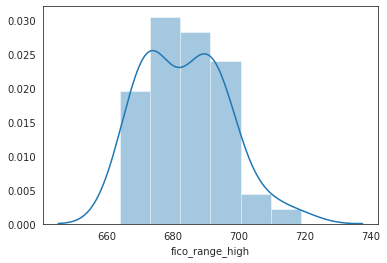

In [98]:
sns.distplot(X_most_50_false_pos_df['fico_range_high'])

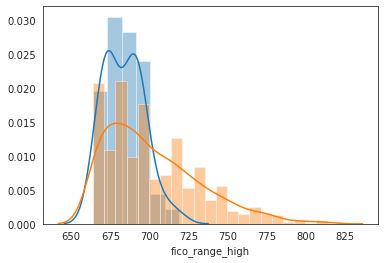

In [114]:
x = X_most_50_false_pos_df['fico_range_high']
y = X_test['fico_range_high']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


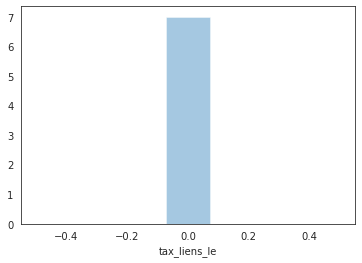

In [99]:
sns.distplot(X_most_50_false_pos_df['tax_liens_le'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


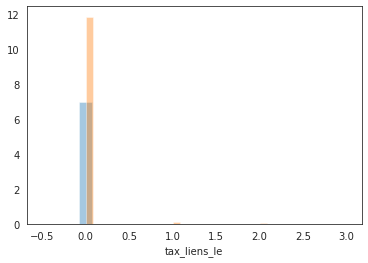

In [115]:
x = X_most_50_false_pos_df['tax_liens_le']
y = X_test['tax_liens_le']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

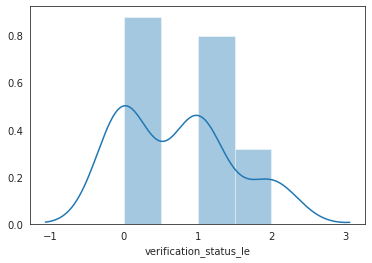

In [100]:
sns.distplot(X_most_50_false_pos_df['verification_status_le'])

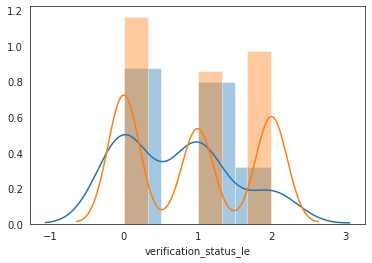

In [116]:
x = X_most_50_false_pos_df['verification_status_le']
y = X_test['verification_status_le']
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

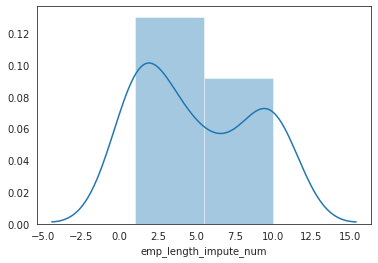

In [102]:
sns.distplot(X_most_50_false_pos_df[X_most_50_false_pos_df['emp_length_impute_num']>=0].emp_length_impute_num)

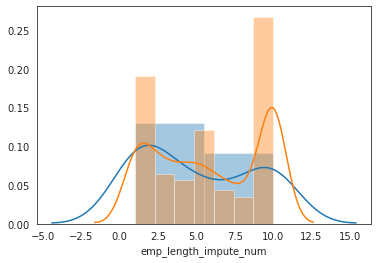

In [118]:
x = X_most_50_false_pos_df[X_most_50_false_pos_df['emp_length_impute_num']>=0].emp_length_impute_num
y = X_test[X_test['emp_length_impute_num']>=0].emp_length_impute_num
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


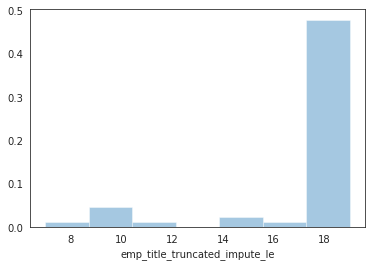

In [103]:
sns.distplot(X_most_50_false_pos_df[X_most_50_false_pos_df['emp_title_truncated_impute_le']>=0].emp_title_truncated_impute_le)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


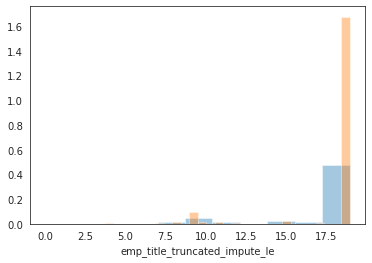

In [119]:
x = X_most_50_false_pos_df[X_most_50_false_pos_df['emp_title_truncated_impute_le']>=0].emp_title_truncated_impute_le
y = X_test[X_test['emp_title_truncated_impute_le']>=0].emp_title_truncated_impute_le
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

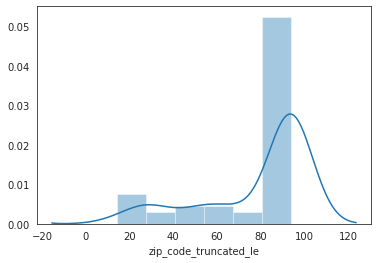

In [104]:

sns.distplot(X_most_50_false_pos_df[X_most_50_false_pos_df['zip_code_truncated_le']>=0].zip_code_truncated_le)

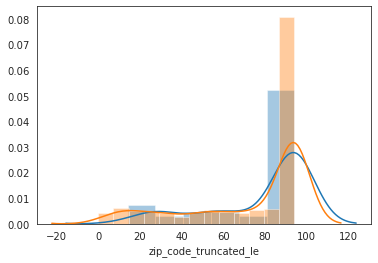

In [120]:
x = X_most_50_false_pos_df[X_most_50_false_pos_df['zip_code_truncated_le']>=0].zip_code_truncated_le
y = X_test[X_test['zip_code_truncated_le']>=0].zip_code_truncated_le
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


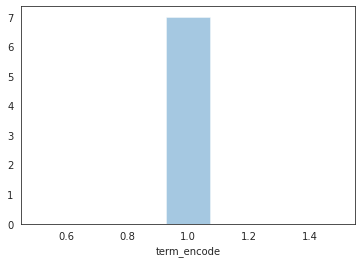

In [105]:
sns.distplot(X_most_50_false_pos_df[X_most_50_false_pos_df['term_encode']>=0].term_encode)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


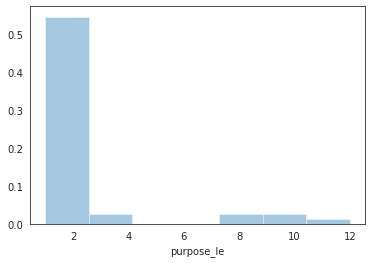

In [106]:

sns.distplot(X_most_50_false_pos_df[X_most_50_false_pos_df['purpose_le']>=0].purpose_le)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


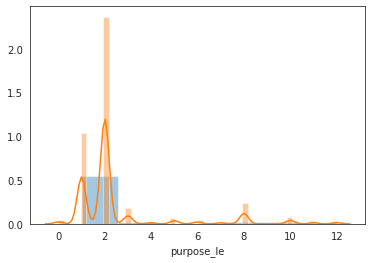

In [121]:
x = X_most_50_false_pos_df[X_most_50_false_pos_df['purpose_le']>=0].purpose_le
y = X_test[X_test['purpose_le']>=0].purpose_le
fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax)